# Homework 2

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting
from matplotlib import cm

import numpy as np
import pandas as pd
from math import ceil, floor 

from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title


# Question 1

In [2]:
%matplotlib inline

def generate_data(N, priors, mu, Sigma, fig_ax=None):
    # Determine dimensionality from mixture PDF parameters
    n = mu.shape[1]

    C = len(priors)
    # Decide randomly which samples will come from each component (taking class 1 from standard normal values above 0.35)
    labels = np.random.rand(N) >= priors[0]
    L = np.array(range(C))
    Nl = np.array([sum(labels == l) for l in L])

    # Draw samples from each class pdf
    X = np.zeros((N, n))

    for i in range(N):
        if labels[i] == 0:
            if np.random.rand(1) > 0.5:
                X[i, :] = multivariate_normal.rvs(mu[0], Sigma[0], 1)
            else:
                X[i, :] = multivariate_normal.rvs(mu[1], Sigma[1], 1)

    X[labels == 1, :] =  multivariate_normal.rvs(mu[2], Sigma[2], Nl[1])


    # Plot the original data and their true labels
    fig = plt.figure(figsize=(10, 10));
    plt.plot(X[labels==0, 0], X[labels==0, 1], 'b.', label="Class 0")
    plt.plot(X[labels==1, 0], X[labels==1, 1], 'm+', label="Class 1")

    plt.legend()
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.title("Class 0 and Class 1 for {0} Samples".format(N))
    plt.grid
    
#     if fig_ax and (0 < n <= 3):
#         if n == 1:
#             fig_ax.scatter(X, np.zeros(N), c=labels)
#         elif n == 2:
#             fig_ax.scatter(X[:, 0], X[:, 1], c=labels)
#             fig_ax.set_ylabel("y-axis")
#             fig_ax.set_aspect('equal')
#         else:
#             fig_ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels)
#             fig_ax.set_ylabel("y-axis")
#             fig_ax.set_zlabel("z-axis")
#             fig_ax.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))

#         fig_ax.set_xlabel("x-axis")
    
    return X, labels
    

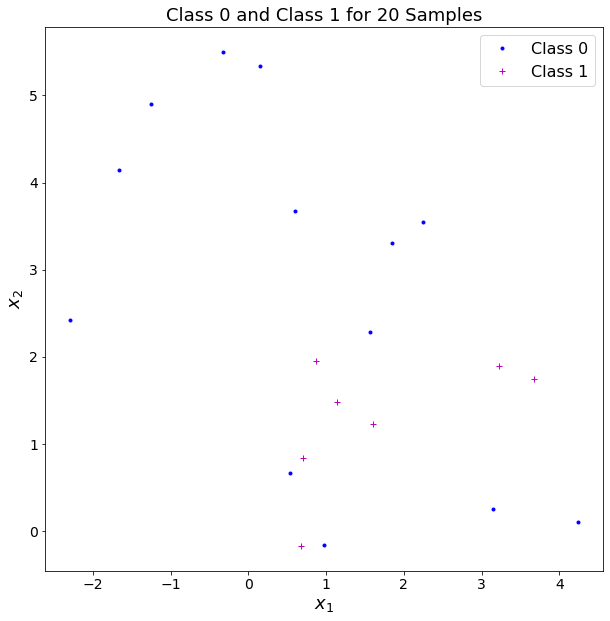

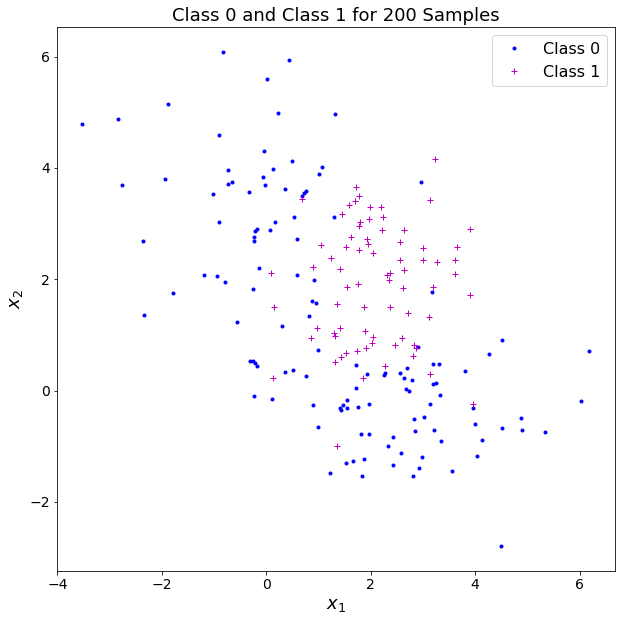

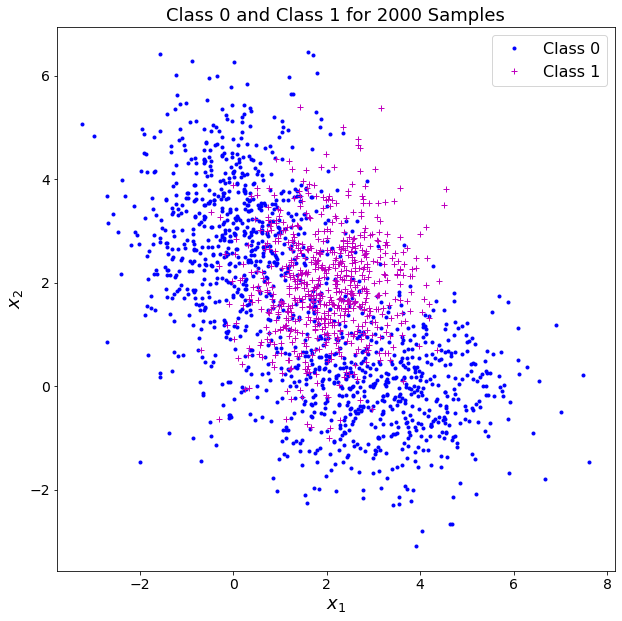

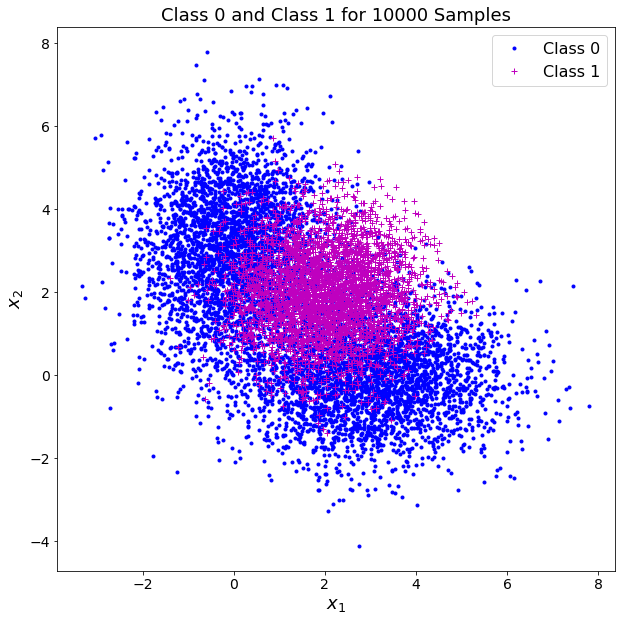

In [3]:
np.random.seed(7)


# Mean and covariance of data pdfs conditioned on labels
mu = np.array([[3, 0],
               [0, 3],
               [2, 2]])
Sigma = np.array([[[2, 0],
                   [0, 1]],
                  [[1, 0],
                   [0, 2]],
                  [[1, 0],
                   [0, 1]]])
# Class priors
priors = np.array([0.65, 0.35])

Xtrain20, labels20 = generate_data(20, priors, mu, Sigma)
Xtrain200, labels200 = generate_data(200, priors, mu, Sigma)
Xtrain2000, labels2000 = generate_data(2000, priors, mu, Sigma)

X, labels = generate_data(10000, priors, mu, Sigma)
    
n = X.shape[1]
num_classes = len(priors)
L = np.array(range(num_classes))
plt.show()

# Count up the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])

In [4]:
Xtrain20[labels20==1, 1]

array([ 1.90065912,  1.23618858,  1.7442712 ,  1.95593174,  0.84436819,
        1.48791802, -0.16867984])

### Part 1

In [5]:
# Generate ROC curve samples
def estimate_roc(discriminant_score, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values that will account for every possible classification split
    gammas = ([sorted_score[0] - float_info.epsilon] +
              sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]
    
    # Retrieve indices where FPs occur
    ind10 = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]
    # Compute FP rates (FPR) as a fraction of total samples in the negative class
    p10 = [len(inds) / N_labels[0] for inds in ind10]
    # Retrieve indices where TPs occur
    ind11 = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]
    # Compute TP rates (TPR) as a fraction of total samples in the positive class
    p11 = [len(inds) / N_labels[1] for inds in ind11]
    
    # ROC has FPR on the x-axis and TPR on the y-axis, but return others as well for convenience
    roc = {}
    roc['p10'] = np.array(p10)
    roc['p11'] = np.array(p11)

    return roc, gammas


def get_binary_classification_metrics(predictions, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Get indices and probability estimates of the four decision scenarios:
    # (true negative, false positive, false negative, true positive)
    class_metrics = {}
    
    # True Negative Probability Rate
    ind_00 = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['tnr'] = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['fpr'] = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['fnr'] = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['tpr'] = len(ind_11) / N_labels[1]

    return class_metrics

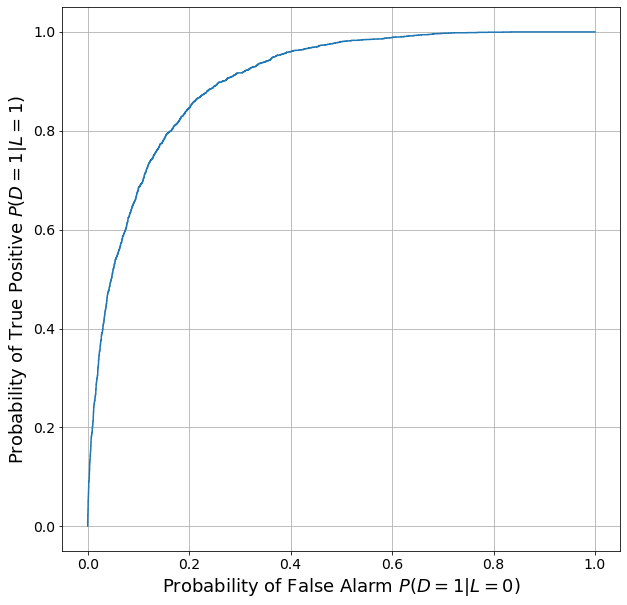

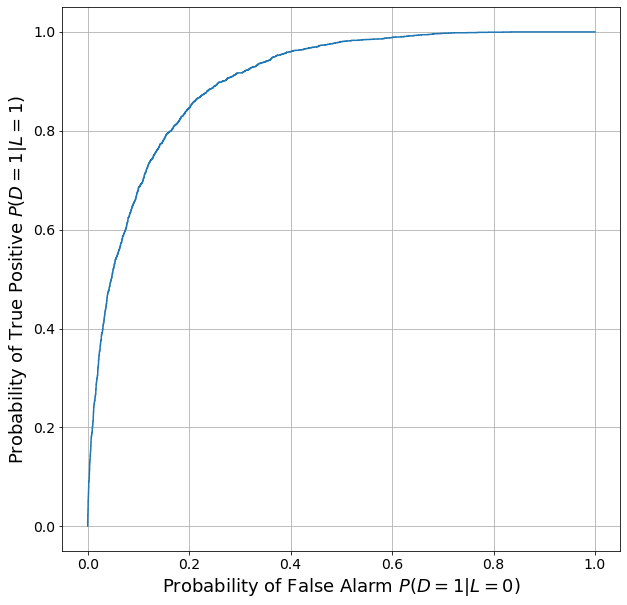

In [6]:
class_cond_lld0 = 0.5 * multivariate_normal.pdf(X, mu[0], Sigma[0]) + 0.5 * multivariate_normal.pdf(X, mu[1], Sigma[1])
class_cond_lld1 = multivariate_normal.pdf(X, mu[2], Sigma[2])
discriminant_score_erm = np.log(class_cond_lld1 / class_cond_lld0)

# Construct the ROC for ERM by changing log(gamma)
roc_erm, gammas_empirical = estimate_roc(discriminant_score_erm, labels)
# roc_erm returns a np.array of shape(2, N+2) where N+2 are the number of thresholds
# and 2 rows are the FPR and TPR respectively

plt.ioff() # Interactive plotting off
fig_roc, ax_roc = plt.subplots(figsize=(10, 10));
plt.ion()

ax_roc.plot(roc_erm['p10'], roc_erm['p11'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $P(D=1|L=1)$")

plt.grid(True)
display(fig_roc)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Min Empirical P(error) for ERM = 0.171
Min Empirical Gamma = 1.888
Min Theoretical P(error) for ERM = 0.172
Min Theoretical Gamma = 1.857


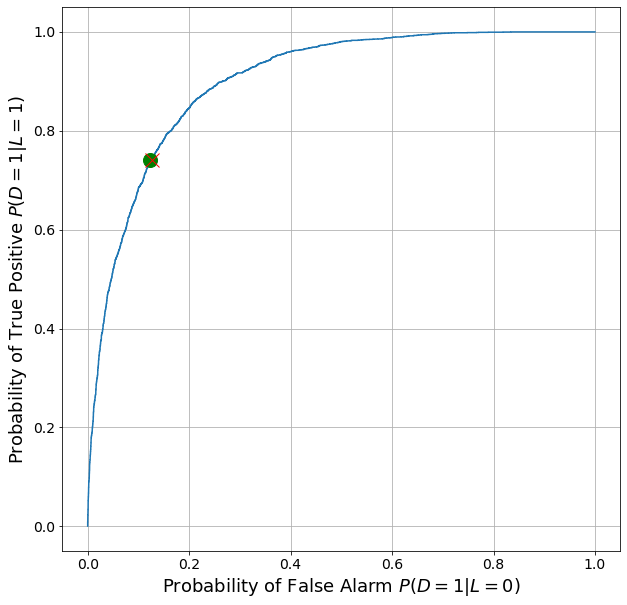

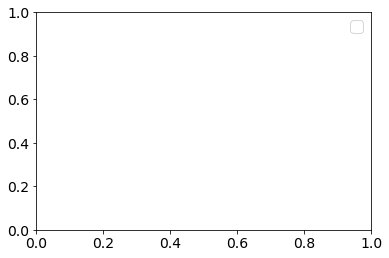

In [7]:
# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
# P(error; γ) = P(D = 1|L = 0; γ)P(L = 0)+P(D = 0|L = 1; γ)P(L = 1)
prob_error_empirical = np.array((roc_erm['p10'], 1 - roc_erm['p11'])).T.dot(N_per_l / 10000)

# Min prob error for the empirically-selected gamma thresholds
min_prob_error_empirical = np.min(prob_error_empirical)
min_ind_empirical = np.argmin(prob_error_empirical)

# Compute theoretical gamma as log-ratio of priors (0-1 loss) -> MAP classification rule
gamma_map = priors[0] / priors[1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

class_metrics_map = get_binary_classification_metrics(decisions_map, labels)
# To compute probability of error, we need FPR and FNR
min_prob_error_map = np.array((class_metrics_map['fpr'] * priors[0] + 
                               class_metrics_map['fnr'] * priors[1]))

# Plot theoretical and empirical
ax_roc.plot(roc_erm['p10'][min_ind_empirical], roc_erm['p11'][min_ind_empirical], 'go', label="Empirical Min P(Error) ERM",
            markersize=14)
ax_roc.plot(class_metrics_map['fpr'], class_metrics_map['tpr'], 'rx', label="Theoretical Min P(Error) ERM", markersize=14)
plt.legend()

print("Min Empirical P(error) for ERM = {:.3f}".format(min_prob_error_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_empirical[min_ind_empirical])))

print("Min Theoretical P(error) for ERM = {:.3f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_map))

display(fig_roc)

### Part 2

In [8]:
# Number of training input samples for experiments
N_train = [20, 200, 2000]
# Number of validation samples for experiments
N_valid = 10000

In [9]:
N_train

[20, 200, 2000]

Generating the training data set; Ntrain = 20
Generating the training data set; Ntrain = 200
Generating the training data set; Ntrain = 2000
Label counts for training sets:  [array([17,  3]), array([136,  64]), array([1276,  724])]
Label counts for validation set:  [6524 3476]


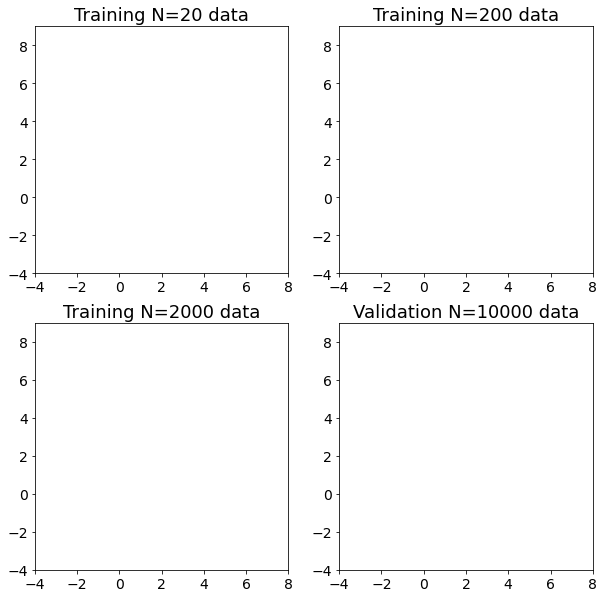

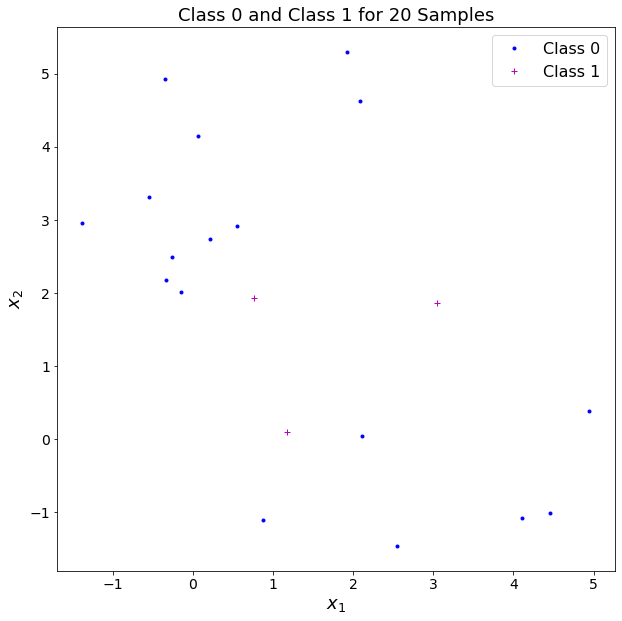

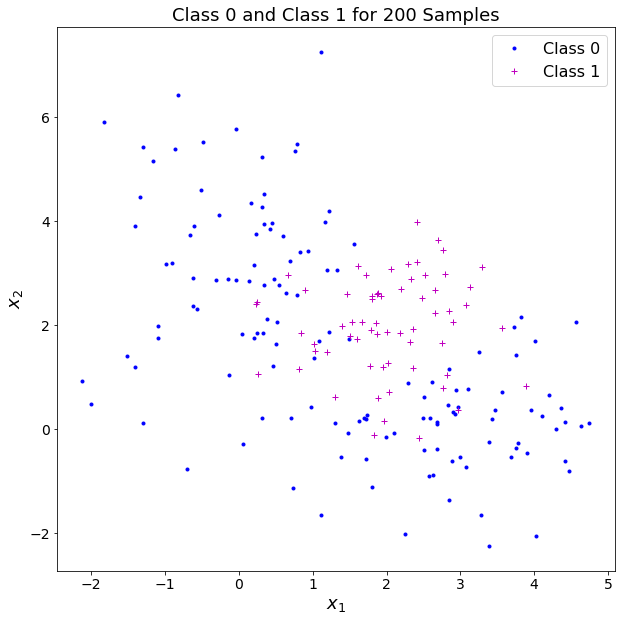

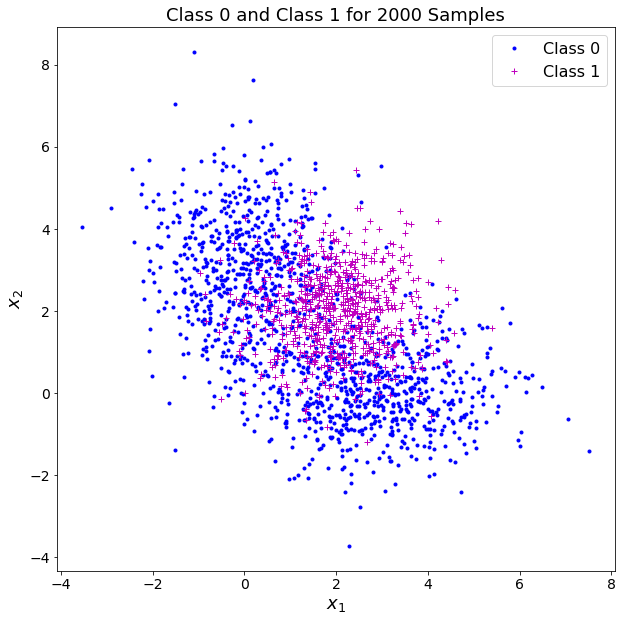

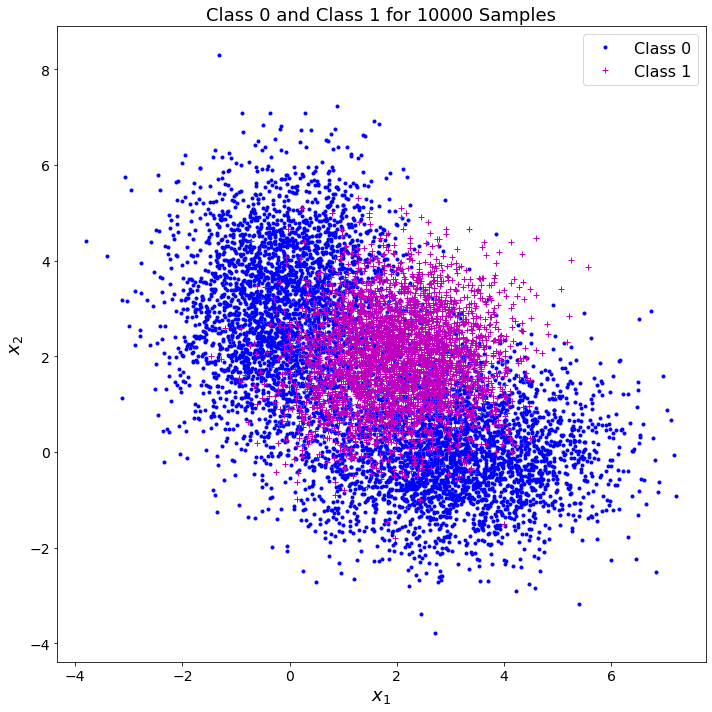

In [10]:
%matplotlib inline

# Create figure outside the generate GMM function, but populate axes within sampling function
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Lists to hold the corresponding input matrices, target vectors and sample label counts per training set
X_train = []
y_train = []
Ny_train = []

# Index for axes
t = 0
for N_t in N_train:
    print("Generating the training data set; Ntrain = {}".format(N_t))
    
    # Modulus to plot in right locations, hacking it
    X_t, y_t = generate_data(N_t, priors, mu, Sigma, fig_ax=ax[floor(t/2), t%2])
    ax[floor(t/2), t%2].set_title("Training N={} data".format(N_t))
    t += 1

    # Prepend column of ones to create augmented inputs tilde{x}
    X_t = np.column_stack((np.ones(N_t), X_t))  
    n = X_t.shape[1]

    Ny_t = np.array((sum(y_t == 0), sum(y_t == 1)))
    
    # Add to lists
    X_train.append(X_t)
    y_train.append(y_t)
    Ny_train.append(Ny_t)

print("Label counts for training sets: ", Ny_train)

# Also generate validation dataset from GMM!
X_valid, y_valid = generate_data(N_valid, priors, mu, Sigma, fig_ax=ax[1, 1])
# Prepend column of ones to create augmented inputs tilde{x}
X_valid = np.column_stack((np.ones(N_valid), X_valid))  
ax[1, 1].set_title("Validation N={} data".format(N_valid))
        
Ny_valid = np.array((sum(y_valid == 0), sum(y_valid == 1)))
print("Label counts for validation set: ", Ny_valid)

# Using validation set samples to limit axes (most samples drawn, highest odds of spanning sample space)
x1_valid_lim = (floor(np.min(X_valid[:,1])), ceil(np.max(X_valid[:,1])))
x2_valid_lim = (floor(np.min(X_valid[:,2])), ceil(np.max(X_valid[:,2])))
plt.setp(ax, xlim=x1_valid_lim, ylim=x2_valid_lim)
plt.tight_layout()
plt.show()

fig;

In [11]:
# Define the logistic/sigmoid function
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Define the prediction function y = 1 / (1 + np.exp(-X*theta))
# X.dot(theta) inputs to the sigmoid referred to as logits
def predict_prob(X, theta):
    logits = X.dot(theta)
    return sigmoid(logits)

# NOTE: This implementation may encounter numerical stability issues... 
# Read into the log-sum-exp trick OR use a method like: sklearn.linear_model import LogisticRegression
def log_reg_loss(theta, X, y):
    # Size of batch
    B = X.shape[0]

    # Logistic regression model g(X * theta)
    predictions = predict_prob(X, theta)

    # NLL loss, 1/N sum [y*log(g(X*theta)) + (1-y)*log(1-g(X*theta))]
    error = predictions - y
    nll = -np.mean(y*np.log(predictions) + (1 - y)*np.log(1 - predictions))
    
    # Partial derivative for GD
    g = (1 / B) * X.T.dot(error)
    
    # Logistic regression loss, NLL (binary cross entropy is another interpretation)
    return nll, g


# Options for mini-batch gradient descent
opts = {}
opts['max_epoch'] = 1000
opts['alpha'] = 1e-3
opts['tolerance'] = 1e-3

opts['batch_size'] = 10

# Breaks the matrix X and vector y into batches
def batchify(X, y, batch_size, N):
    X_batch = []
    y_batch = []

    # Iterate over N in batch_size steps, last batch may be < batch_size
    for i in range(0, N, batch_size):
        nxt = min(i + batch_size, N + 1)
        X_batch.append(X[i:nxt, :])
        y_batch.append(y[i:nxt])

    return X_batch, y_batch


def gradient_descent(loss_func, theta0, X, y, N, *args, **kwargs):
    # Mini-batch GD. Stochastic GD if batch_size=1.

    # Break up data into batches and work out gradient for each batch
    # Move parameters theta in that direction, scaled by the step size.

    # Options for total sweeps over data (max_epochs),
    # and parameters, like learning rate and threshold.

    # Default options
    max_epoch = kwargs['max_epoch'] if 'max_epoch' in kwargs else 200
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
    epsilon = kwargs['tolerance'] if 'tolerance' in kwargs else 1e-6

    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 10

    # Turn the data into batches
    X_batch, y_batch = batchify(X, y, batch_size, N)
    num_batches = len(y_batch)
    print("%d batches of size %d\n" % (num_batches, batch_size))

    theta = theta0
    m_t = np.zeros(theta.shape)

    trace = {}
    trace['loss'] = []
    trace['theta'] = []

    # Main loop:
    for epoch in range(1, max_epoch + 1):
        # print("epoch %d\n" % epoch)
        
        loss_epoch = 0
        for b in range(num_batches):
            X_b = X_batch[b]
            y_b = y_batch[b]
            # print("epoch %d batch %d\n" % (epoch, b))

            # Compute NLL loss and gradient of NLL function
            loss, gradient = loss_func(theta, X_b, y_b, *args)
            loss_epoch += loss
            
            # Steepest descent update
            theta = theta - alpha * gradient
            
            # Terminating Condition is based on how close we are to minimum (gradient = 0)
            if np.linalg.norm(gradient) < epsilon:
                print("Gradient Descent has converged after {} epochs".format(epoch))
                break
                
        # Storing the history of the parameters and loss values per epoch
        trace['loss'].append(np.mean(loss_epoch))
        trace['theta'].append(theta)
        
        # Also break epochs loop
        if np.linalg.norm(gradient) < epsilon:
            break

    return theta, trace

# Can also use: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
def quadratic_transformation(X):
    n = X.shape[1]
    phi_X = X
    
    # Take all monic polynomials for a quadratic
    phi_X = np.column_stack((phi_X, X[:, 1] * X[:, 1], X[:, 1] * X[:, 2], X[:, 2] * X[:, 2]))
        
    return phi_X

In [12]:
# Use the validation set's sample space to bound the grid of inputs
# Work out bounds that span the input feature space (x_1 and x_2)
bounds_X = np.array((floor(np.min(X_valid[:,1])), ceil(np.max(X_valid[:,1]))))
bounds_Y = np.array((floor(np.min(X_valid[:,2])), ceil(np.max(X_valid[:,2]))))

def create_prediction_score_grid(theta, poly_type='L'):
    # Create coordinate matrices determined by the sample space; can add finer intervals than 100 if desired
    xx, yy = np.meshgrid(np.linspace(bounds_X[0], bounds_X[1], 200), np.linspace(bounds_Y[0], bounds_Y[1], 200))

    # Augment grid space with bias ones vector and basis expansion if necessary
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_aug = np.column_stack((np.ones(200*200), grid)) 
    if poly_type == 'Q':
        grid_aug = quadratic_transformation(grid_aug)

    # Z matrix are the predictions resulting from sigmoid on the provided model parameters
    Z = predict_prob(grid_aug, theta).reshape(xx.shape)
    
    return xx, yy, Z


def plot_prediction_contours(X, theta, ax, poly_type='L'):
    xx, yy, Z = create_prediction_score_grid(theta, poly_type)
    # Once reshaped as a grid, plot contour of probabilities per input feature (ignoring bias)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.55)
    ax.set_xlim([bounds_X[0], bounds_X[1]])
    ax.set_ylim([bounds_Y[0], bounds_Y[1]])

    
def plot_decision_boundaries(X, labels, theta, ax, poly_type='L'): 
    # Plots original class labels and decision boundaries
    ax.plot(X[labels==0, 1], X[labels==0, 2], 'o', label="Class 0")
    ax.plot(X[labels==1, 1], X[labels==1, 2], '+', label="Class 1")
    
    xx, yy, Z = create_prediction_score_grid(theta, poly_type)
    # Once reshaped as a grid, plot contour of probabilities per input feature (ignoring bias)
    cs = ax.contour(xx, yy, Z, levels=1, colors='k')

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_aspect('equal')

    
def report_logistic_classifier_results(X, theta, labels, N_labels, ax, poly_type='L'):
    """
    Report the probability of error and plot the classified data, plus predicted 
    decision contours of the logistic classifier applied to the data given.
    """
    
    predictions = predict_prob(X, theta)  
    # Predicted decisions based on the default 0.5 threshold (higher probability mass on one side or the other)
    decisions = np.array(predictions >= 0.5)
    
    # True Negative Probability Rate
    ind_00 = np.argwhere((decisions == 0) & (labels == 0))
    tnr = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((decisions == 1) & (labels == 0))
    fpr = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((decisions == 0) & (labels == 1))
    fnr = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((decisions == 1) & (labels == 1))
    tpr = len(ind_11) / N_labels[1]

    prob_error = fpr*priors[0] + fnr*priors[1]

    print("The total error achieved with this classifier is {:.3f}".format(prob_error))
    
    # Plot all decisions (green = correct, red = incorrect)
    ax.plot(X[ind_00, 1], X[ind_00, 2], '.g', label="Class 0 Correct", alpha=.25)
    ax.plot(X[ind_10, 1], X[ind_10, 2], '.r', label="Class 0 Wrong")
    ax.plot(X[ind_01, 1], X[ind_01, 2], '+r', label="Class 1 Wrong")
    ax.plot(X[ind_11, 1], X[ind_11, 2], '+g', label="Class 1 Correct", alpha=.25)

    # Draw the decision boundary based on whether its linear (L) or quadratic (Q)
    plot_prediction_contours(X, theta, ax, poly_type)
    ax.set_aspect('equal')

Training the logistic-linear model with GD per data subset
2 batches of size 10

Logistic-Linear N=20 GD Theta: [-1.48307317  0.25998024 -0.24329881]
Logistic-Linear N=20 NLL: 0.8871320559409608
The total error achieved with this classifier is 0.367
20 batches of size 10

Logistic-Linear N=200 GD Theta: [-1.77237856  0.37036364  0.2544544 ]
Logistic-Linear N=200 NLL: 11.668499683765404
The total error achieved with this classifier is 0.356
200 batches of size 10

Logistic-Linear N=2000 GD Theta: [-2.04740613  0.44386236  0.40468598]
Logistic-Linear N=2000 NLL: 121.24546478967504
The total error achieved with this classifier is 0.344


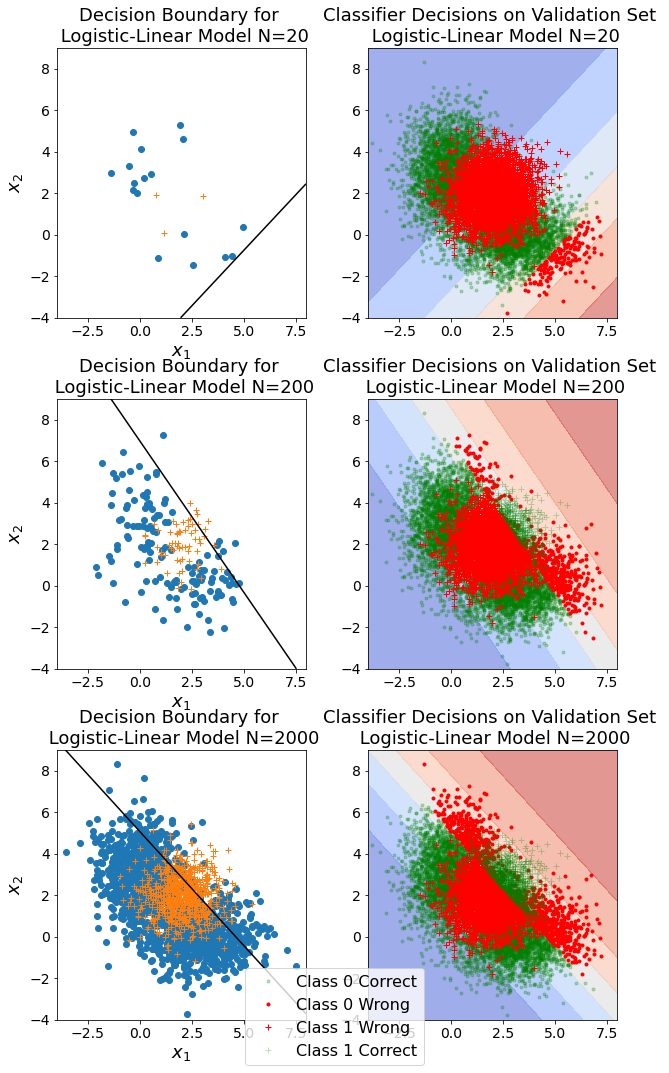

In [13]:
# Starting point from to search for optimal parameters
theta0_linear = np.random.randn(n)

fig_decision, ax_decision = plt.subplots(3, 2, figsize=(15, 15));

print("Training the logistic-linear model with GD per data subset"),
for i in range(len(N_train)):
    shuffled_indices = np.random.permutation(N_train[i]) 
    
    # Shuffle row-wise X (i.e. across training examples) and labels using same permuted order
    X = X_train[i][shuffled_indices]
    y = y_train[i][shuffled_indices]

    theta_gd, trace = gradient_descent(log_reg_loss, theta0_linear, X, y, N_train[i], **opts)

    print("Logistic-Linear N={} GD Theta: {}".format(N_train[i], theta_gd))
    print("Logistic-Linear N={} NLL: {}".format(N_train[i], trace['loss'][-1]))

    # Convert our trace of parameter and loss function values into NumPy "history" arrays:
    theta_hist = np.asarray(trace['theta'])
    nll_hist = np.array(trace['loss'])
    
    plot_decision_boundaries(X, y, theta_gd, ax_decision[i, 0])
    ax_decision[i, 0].set_title("Decision Boundary for \n Logistic-Linear Model N={}".format(X.shape[0]))

    # Linear: use validation data (10k samples) and make decisions in report results routine
    report_logistic_classifier_results(X_valid, theta_gd, y_valid, Ny_valid, ax_decision[i, 1])
    ax_decision[i, 1].set_title("Classifier Decisions on Validation Set \n Logistic-Linear Model N={}".format(N_train[i]))

# Again use the most sampled subset (validation) to define x-y limits
plt.setp(ax_decision, xlim=x1_valid_lim, ylim=x2_valid_lim)

# Adjust subplot positions
plt.subplots_adjust(left=0.05,
                    bottom=0.05, 
                    right=0.6, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.3)

# Super plot the legends
handles, labels = ax_decision[0, 1].get_legend_handles_labels()
fig_decision.legend(handles, labels, loc='lower center')

plt.show()

Training the logistic-quadratic model with GD per data subset
2 batches of size 10

Logistic-Quadratic N=20 GD Theta: [-0.87722181 -0.97403371 -0.12611805  0.13608175  0.65141771 -0.24806907]
Logistic-Quadratic N=20 NLL: 0.5537991877833307
The total error achieved with this classifier is 0.321
20 batches of size 10

Logistic-Quadratic N=200 GD Theta: [-0.50617548  0.06774617  0.32944099 -0.40332626  1.10923512 -0.44007848]
Logistic-Quadratic N=200 NLL: 6.445846317370367
The total error achieved with this classifier is 0.170
200 batches of size 10

Logistic-Quadratic N=2000 GD Theta: [-1.29519444  0.74440295  0.9029202  -0.35726451  0.63322875 -0.4141242 ]
Logistic-Quadratic N=2000 NLL: 77.80718238142765
The total error achieved with this classifier is 0.166


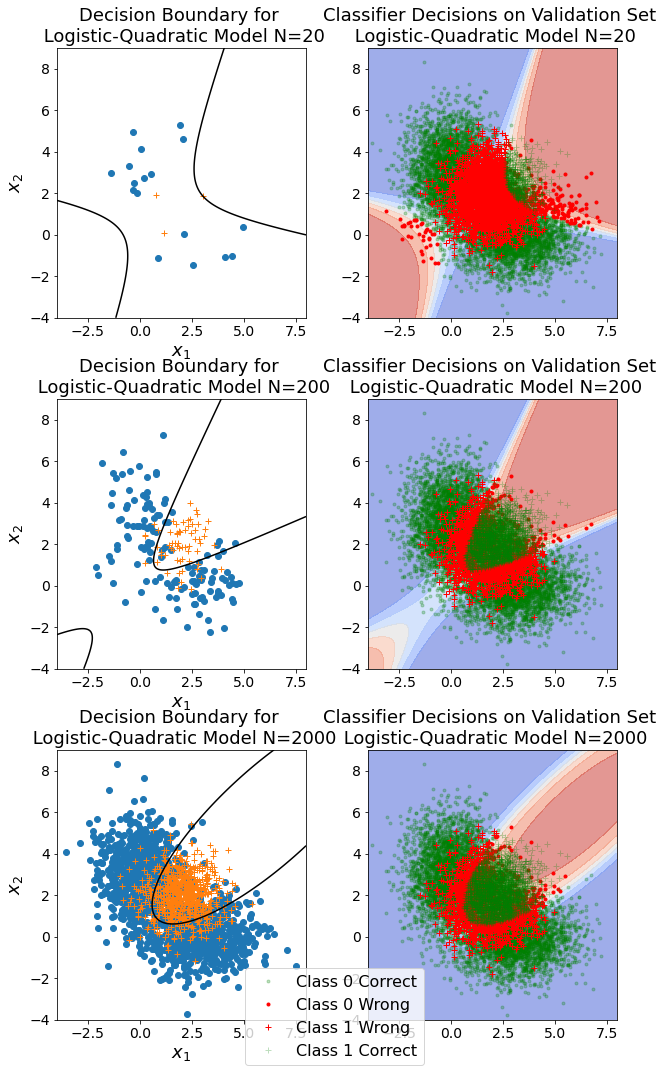

In [14]:
# NOTE that the initial parameters have added dimensionality to match the basis expansion set
theta0_quadratic = np.random.randn(n+3)

fig_decision, ax_decision = plt.subplots(3, 2, figsize=(15, 15));

print("Training the logistic-quadratic model with GD per data subset"),
for i in range(len(N_train)):
    shuffled_indices = np.random.permutation(N_train[i]) 
    
    # Shuffle row-wise X (i.e. across training examples) and labels using same permuted order
    X = X_train[i][shuffled_indices]
    y = y_train[i][shuffled_indices]
    
    # Important transformation line to add monic polynomial terms for a quadratic
    X_quad = quadratic_transformation(X)
    theta_gd, trace = gradient_descent(log_reg_loss, theta0_quadratic, X_quad, y, N_train[i], **opts)

    print("Logistic-Quadratic N={} GD Theta: {}".format(N_train[i], theta_gd))
    print("Logistic-Quadratic N={} NLL: {}".format(N_train[i], trace['loss'][-1]))

    # Convert our trace of parameter and loss function values into NumPy "history" arrays:
    theta_hist = np.asarray(trace['theta'])
    nll_hist = np.array(trace['loss'])
    
    plot_decision_boundaries(X_quad, y, theta_gd, ax_decision[i, 0], poly_type='Q')
    ax_decision[i, 0].set_title("Decision Boundary for \n Logistic-Quadratic Model N={}".format(X.shape[0]))

    # Quadratic: use validation data (10k samples) and make decisions in report results routine
    X_valid_quad = quadratic_transformation(X_valid)
    report_logistic_classifier_results(X_valid_quad, theta_gd, y_valid, Ny_valid, ax_decision[i, 1], poly_type='Q')
    ax_decision[i, 1].set_title("Classifier Decisions on Validation Set \n Logistic-Quadratic Model N={}".format(N_train[i]))


# Again use the most sampled subset (validation) to define x-y limits
plt.setp(ax_decision, xlim=x1_valid_lim, ylim=x2_valid_lim)

# Adjust subplot positions
plt.subplots_adjust(left=0.05,
                    bottom=0.05, 
                    right=0.6, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.3)

# Super plot the legends
handles, labels = ax_decision[0, 1].get_legend_handles_labels()
fig_decision.legend(handles, labels, loc='lower center')

plt.show()